In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
import torch
from tqdm.auto import tqdm

from sentence_transformers import SentenceTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-22 22:18:17.358583: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-22 22:18:17.365768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750601897.375594   64030 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750601897.378547   64030 cuda_blas.cc:1407

In [3]:
# -------------------- data --------------------
train_df = pd.read_excel("../Datasets/Train.xlsx")
test_df  = pd.read_excel("../Datasets/Test.xlsx")

X_full = train_df["Review Comment"]
y_full = train_df["Expected Operation by Developer"]

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.10, random_state=SEED, stratify=y_full
)

print("Train size:", len(X_train), "   Val size:", len(X_val))

Train size: 837    Val size: 94


In [4]:
# -------------------- sentence-transformer embeddings --------------------
device   = "cuda" if torch.cuda.is_available() else "cpu"   # keep GPU for fast encoding
embedder = SentenceTransformer("all-MiniLM-L6-v2", device=device)

def embed(texts):
    return embedder.encode(texts.tolist(), show_progress_bar=True,
                           batch_size=64, device=device)

Xtr_emb  = embed(X_train)
Xval_emb = embed(X_val)

Batches: 100%|██████████| 2/2 [00:00<00:00, 30.73it/s]


In [5]:
# -------------------- Decision Tree + grid search --------------------
base_dt = DecisionTreeClassifier(random_state=SEED)

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

search = GridSearchCV(
    base_dt, param_grid,
    cv=5, n_jobs=-1, scoring="accuracy", verbose=1
)
search.fit(Xtr_emb, y_train)

print("Best CV-acc :", search.best_score_)
print("Best params:", search.best_params_)
best_dt = search.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Best CV-acc : 0.4421086398631308
Best params: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [6]:
# -------------------- retrain on full train set --------------------
X_full_emb = embed(X_full)
best_dt.fit(X_full_emb, y_full)

Batches: 100%|██████████| 15/15 [00:00<00:00, 64.89it/s]


DecisionTreeClassifier(min_samples_leaf=2, random_state=42)

Batches: 100%|██████████| 4/4 [00:00<00:00, 46.26it/s]


Test accuracy: 0.3932

              precision    recall  f1-score   support

      delete       0.40      0.44      0.42        78
      insert       0.35      0.38      0.37        81
     replace       0.44      0.36      0.39        75

    accuracy                           0.39       234
   macro avg       0.40      0.39      0.39       234
weighted avg       0.40      0.39      0.39       234



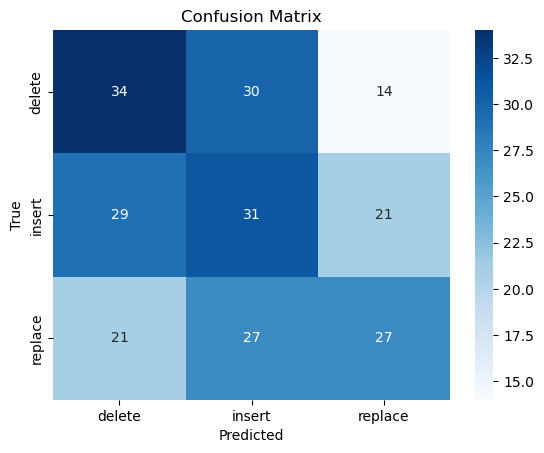

In [7]:
# -------------------- test evaluation --------------------
X_test     = test_df["Review Comment"].astype(str)
y_test     = test_df["Expected Operation by Developer"]
Xtest_emb  = embed(X_test)

y_pred = best_dt.predict(Xtest_emb)
acc    = accuracy_score(y_test, y_pred)
print(f"\nTest accuracy: {acc:.4f}\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_full))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_full),
            yticklabels=np.unique(y_full))
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()


In [8]:
# -------------------- inspect feature importances --------------------
feat_import = best_dt.feature_importances_
top = np.argsort(feat_import)[-10:][::-1]
print("Top 10 embedding dimensions by importance:", top)

Top 10 embedding dimensions by importance: [376 286 319 220  39   2  61 165 345 277]
